# Lesson 2

17.03.2023

## Фильтрация изображений

Подключаем необходимые либы

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Прежде, чем фильтровать изображение посмотрим еще один тип шума: высокочастотный

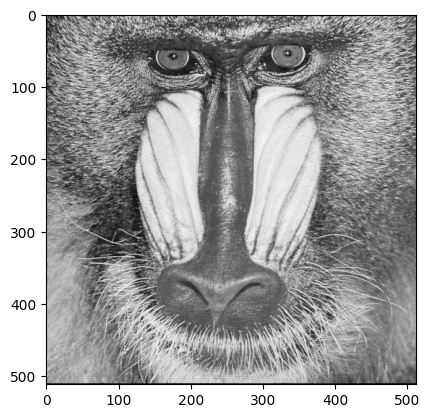

In [62]:
fileName = 'Mandrill.png'
img = cv2.imread(fileName)
if len(img.shape) > 2:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.imshow(img, cmap='gray')

Генерируем шум

In [3]:
M, N = img.shape

In [43]:
# Генерируем случайную частоту
f = np.random.randint(1, 5000)
# Выбираем случайную частоту дискретизации (> 2*f)
fs = np.random.randint(2, 10) * f
# Считаем период дискретизации
ts = 1/fs
t = np.arange(0, M*N, 1)
# Дискретизируем сигнал
T = np.array(t) * ts

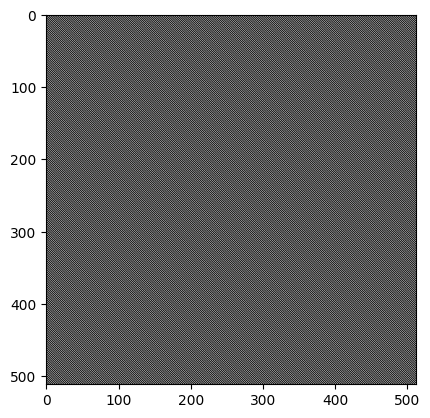

In [44]:
# Получаем зашумленный сигнал
dirty_cos = np.cos(2 * np.pi * f * T) * 255;
# Перегоняем его в размер изображения
dirty_cos = np.reshape(dirty_cos, (M, N)).astype('uint8')

plt.imshow(dirty_cos, cmap='gray')

Добавим полученный шум к изображению

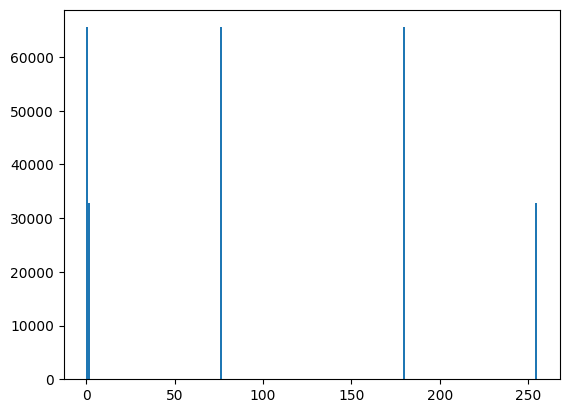

In [20]:
plt.hist(dirty_cos.ravel(), bins=256)
plt.show()

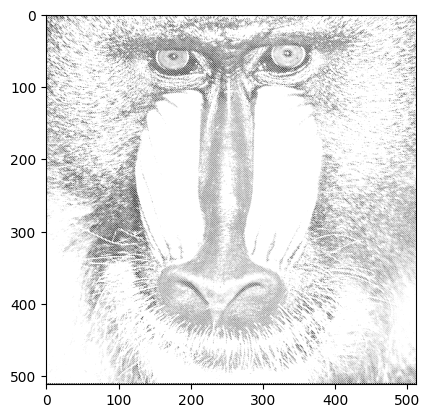

In [46]:
hf_img = cv2.add(img, dirty_cos)
plt.imshow(hf_img, cmap='gray')

Теперь переходим к фильтрации изображений

Сначала попробуем отфильтровать импульсный шум

Для этого будем использовать скользящую медиану

(512, 512)


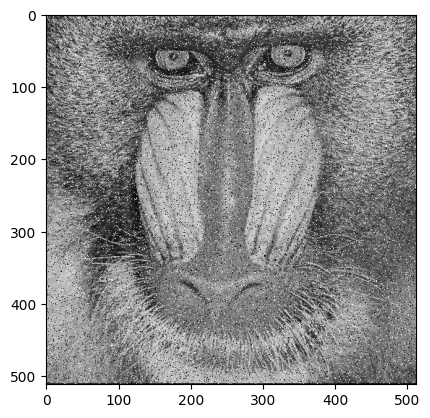

In [25]:
dirty_img = cv2.imread('Noisy_Mandrill.png', cv2.IMREAD_GRAYSCALE)
print(dirty_img.shape)

plt.imshow(dirty_img, cmap='gray')

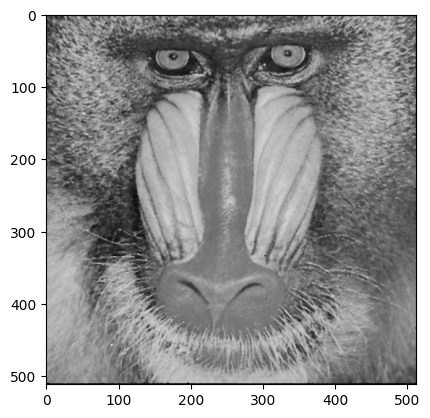

In [38]:
dirty_img2 = cv2.copyMakeBorder(dirty_img, 1, 1, 1, 1, cv2.BORDER_CONSTANT)

M, N = dirty_img2.shape

# plt.imshow(dirty_img, cmap='gray')

dirty_img3 = np.zeros((M,N))

for i in range(1, M-1):
    for j in range(1, N-1):
        window = [
            dirty_img2[i-1, j-1],   dirty_img2[i, j-1],     dirty_img2[i+1, j-1],
            dirty_img2[i-1, j],     dirty_img2[i, j],       dirty_img2[i+1, j],
            dirty_img2[i-1, j+1],   dirty_img2[i, j+1],     dirty_img2[i+1, j+1],
        ]
        
        dirty_img3[i, j] = np.median(window)

clean_img = dirty_img3[1:M-1, 1:N-1]

plt.imshow(clean_img, cmap='gray')

In [37]:
print(dirty_img2.shape)

print(clean_img.shape)

(514, 514)
(512, 512)


Попробуем отфильтровать наш ВЧ-шум при помощи скользящего среднего

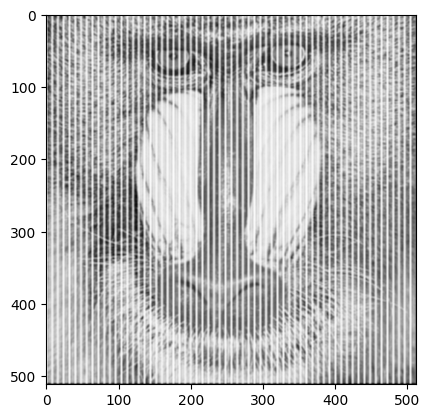

In [41]:
hf_img2 = cv2.copyMakeBorder(hf_img, 1, 1, 1, 1, cv2.BORDER_CONSTANT)

M, N = hf_img2.shape

# plt.imshow(dirty_img, cmap='gray')

hf_img3 = np.zeros((M,N))

for i in range(1, M-1):
    for j in range(1, N-1):
        window = [
            hf_img2[i-1, j-1],   hf_img2[i, j-1],     hf_img2[i+1, j-1],
            hf_img2[i-1, j],     hf_img2[i, j],       hf_img2[i+1, j],
            hf_img2[i-1, j+1],   hf_img2[i, j+1],     hf_img2[i+1, j+1],
        ]
        
        hf_img3[i, j] = np.mean(window)

clean_hf_img = hf_img3[1:M-1, 1:N-1]

plt.imshow(clean_hf_img, cmap='gray')

Поймем, что выходит не очень. И будем использовать другой способ

Для начала посмотрим двух-мерный Фурье-спектр

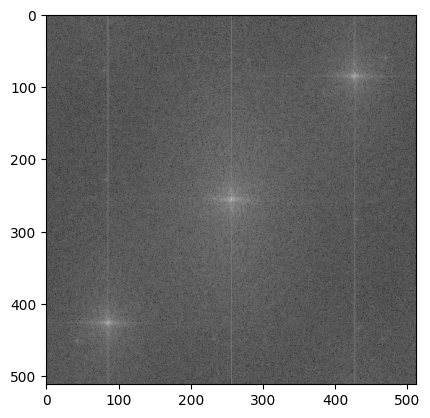

In [57]:
M, N = hf_img.shape

fft2 = np.fft.fft2(hf_img)
ft = np.fft.fftshift(fft2)

plt.imshow(np.log(np.abs(ft)), cmap='gray')

Видим те части, которые нам нужно отфильтровать

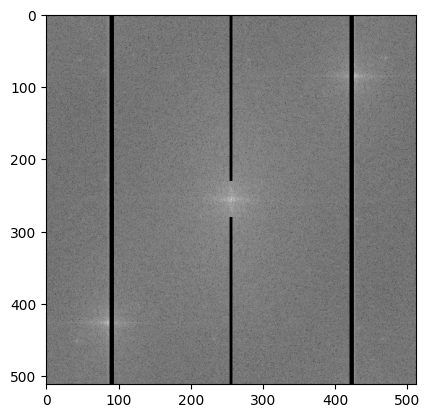

In [58]:
N2 = int(N/2)
M2 = int(M/2)

ft[:M2 - 25, N2 - 2: N2 + 2] = 1
ft[M2 + 25:, N2 - 2: N2 + 2] = 1

ft[:, 88:94] = 1
ft[:, 420:426] = 1

plt.imshow(np.log(np.abs(ft)), cmap='gray')

После того, как мы отфильтровали нужные области, возвращаем изображению нормальный вид

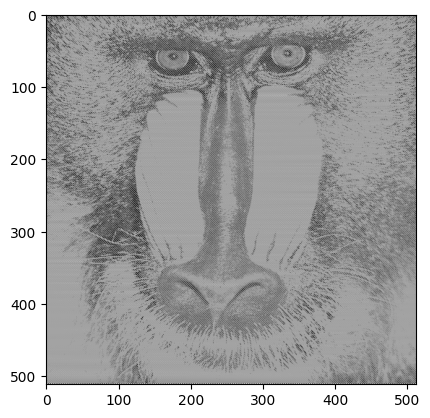

In [59]:
restored_img = abs(np.fft.ifft2(ft))

plt.imshow(restored_img, cmap='gray')

## Другие операции с изображениями

Необходима библиотека scikit-image

In [60]:
from skimage.exposure import rescale_intensity

In [61]:
def convolve(image, kernel):
	# считываем размеры изображения и ядра свертки
	(iH, iW) = image.shape[:2]
	(kH, kW) = kernel.shape[:2]
	# делаем паддинг для изображения
	pad = (kW - 1) // 2
	image = cv2.copyMakeBorder(image, pad, pad, pad, pad,
		cv2.BORDER_REPLICATE)
    # создаем пустое изображение, в которое будем записывать результат
	output = np.zeros((iH, iW), dtype="float32")
    # итерируемся по x и y
	for y in np.arange(pad, iH + pad):
		for x in np.arange(pad, iW + pad):
			# выхватываем окно
			roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]
			# и сворачиваем его с ядром
			k = (roi * kernel).sum()
			output[y - pad, x - pad] = k
    # rescale the output image to be in the range [0, 255]
	output = rescale_intensity(output, in_range=(0, 255))
	output = (output * 255).astype("uint8")
	# return the output image
	return output

In [64]:
# шарпенинг (повышение резкости)
sharpen = np.array((
	[0, -1, 0],
	[-1, 5, -1],
	[0, -1, 0]), dtype="int")

# выделение границ
laplacian = np.array((
	[0, 1, 0],
	[1, -4, 1],
	[0, 1, 0]), dtype="int")

sobelX = np.array((
	[-1, 0, 1],
	[-2, 0, 2],
	[-1, 0, 1]), dtype="int")

sobelY = np.array((
	[-1, -2, -1],
	[0, 0, 0],
	[1, 2, 1]), dtype="int")

prewittX = np.array((
	[-1, 0, 1],
	[-1, 0, 1],
	[-1, 0, 1]), dtype="int")

prewittY = np.array((
	[-1, -1, -1],
	[0, 0, 0],
	[1, 1, 1]), dtype="int")

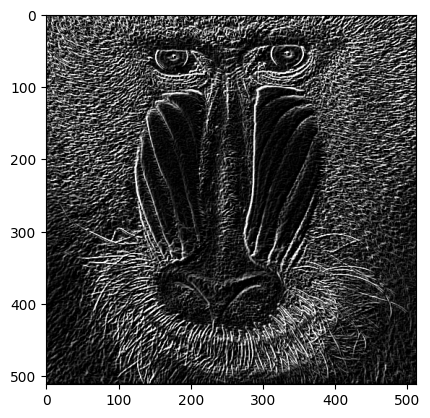

In [70]:
resultX = convolve(img, prewittX)
resultY = convolve(img, prewittY)

result = cv2.add(resultX, resultY)

plt.imshow(result, cmap='gray')

Эквализация гистограммы

$ 255 * \left( \frac{I - I_{min}}{I_{max}-I_{min}} \right) $

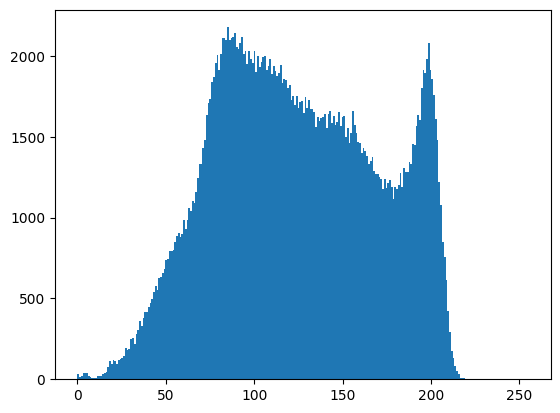

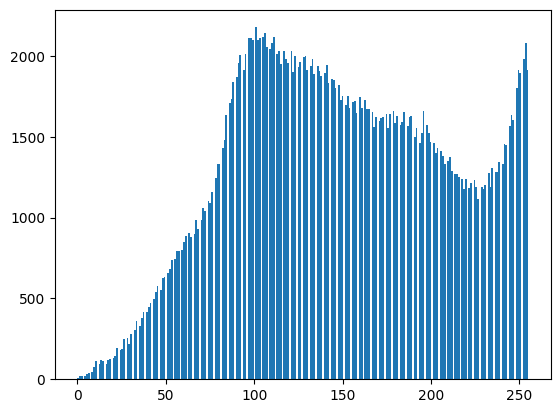

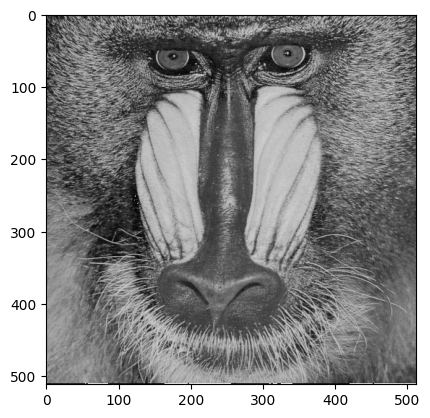

In [77]:
plt.hist(img.ravel(), 256, [0, 255])
plt.show()

Imin = 10
Imax = 200

img_eq = 255 * ((img - Imin)/(Imax - Imin))

plt.hist(img_eq.ravel(), 256, [0, 255])
plt.show()

plt.imshow(img_eq, cmap='gray')

Гамма-коррекция

$ \left( \Big(\frac{I}{255}\Big)^{\frac{1}{\gamma}} \right)*255 $

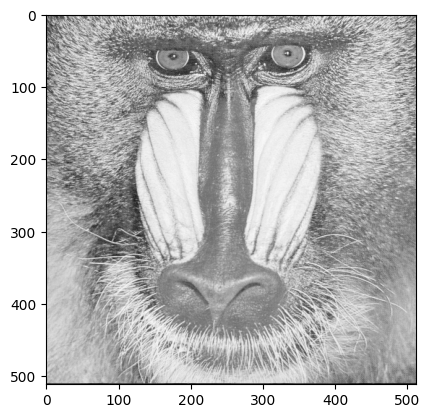

In [85]:
gamma = 1.5
invGamma = 1 / gamma

table = [((i / 255) ** invGamma) * 255 for i in range(256)]
table = np.array(table, np.uint8)

img_c = cv2.LUT(img, table)

plt.imshow(img_c, cmap='gray')

Бинаризация

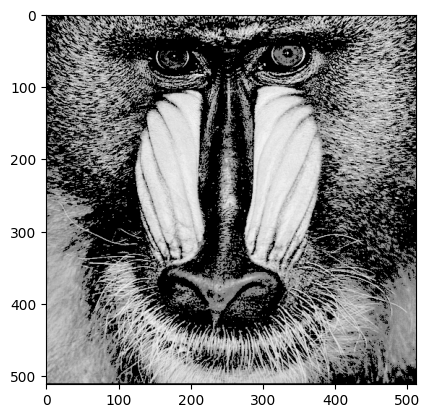

In [88]:
thr = 100
img_bin = (img > thr) * img

plt.imshow(img_bin, cmap='gray')